<a href="https://colab.research.google.com/github/shreydan/fastai-starters/blob/main/fastai_torchvision_dls_cyclicLR_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR100
import torchvision.transforms as t
from fastai.vision.all import *

In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_tfms = t.Compose([
    t.Resize(64),
    t.RandomHorizontalFlip(p=1),
    t.RandomRotation(10),
    t.ToTensor(),
    t.Normalize(mean=mean, std=std, inplace=True)
])
val_tfms = t.Compose([
    t.Resize(64),
    t.ToTensor(),
    t.Normalize(mean=mean, std=std, inplace=True)
])

In [3]:
train_ds = CIFAR100('./cifar100/',train=True,download=True,transform=train_tfms)
val_ds = CIFAR100('./cifar100/',train=False,transform=val_tfms)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar100/cifar-100-python.tar.gz to ./cifar100/


In [4]:
classes = dict(zip(range(100), train_ds.classes))

In [5]:
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=64, 
                                       shuffle=True, 
                                       num_workers=2,
                                       pin_memory=True
                                       )
val_dl = torch.utils.data.DataLoader(val_ds, 
                                       batch_size=64, 
                                       shuffle=True, 
                                       num_workers=2,
                                     pin_memory=True
                                       )

dls = DataLoaders(train_dl, val_dl)

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(SimpleCNN, self).__init__()
        self.num_classes = num_classes
        self.model = nn.Sequential(
            nn.Conv2d(3,16,3,1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16,32,3,1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32,64,3,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64,128,3,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.AdaptiveAvgPool1d(256),
            nn.Linear(256,self.num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [7]:
x = torch.rand(1,3,64,64)
m = SimpleCNN()
m(x).shape

torch.Size([1, 100])

In [8]:
learner = Learner(dls, 
                  SimpleCNN(),
                  loss_func = nn.CrossEntropyLoss(),
                  metrics=[accuracy, error_rate]
                  )

SuggestedLRs(valley=0.0063095735386013985)

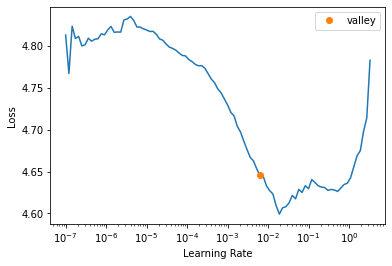

In [9]:
learner.lr_find()

In [10]:
learner.fit_one_cycle(20, 
                      lr_max=6e-3, 
                      cbs = [
                          EarlyStoppingCallback(monitor='valid_loss',
                                                patience=3
                                                )
                          ]
                      )

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.277142,3.247520,0.218600,0.781400,00:32
1,2.861996,2.889049,0.285700,0.714300,00:31
2,2.593946,2.951011,0.290100,0.709900,00:31
3,2.382618,2.590733,0.356100,0.643900,00:31
4,2.254440,2.353124,0.396200,0.603800,00:32
5,2.059983,2.272073,0.417200,0.582800,00:32
6,1.915389,2.150648,0.448400,0.551600,00:31
7,1.805952,2.131523,0.461300,0.538700,00:31
8,1.748601,2.062801,0.468800,0.531200,00:32
9,1.680453,2.060281,0.465900,0.534100,00:31
